In [226]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [227]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)
# sales_data

In [228]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [229]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [230]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [231]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [232]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category2

# Remove Outliers

In [233]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(30)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [234]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

# Adding Lagged Variables

In [235]:
lags = [1,2,3,4]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3','lag4']
category = category[selected_columns]

# Normalization

In [236]:
scaler = MinMaxScaler()
X = scaler.fit_transform(category.drop(category.columns[0], axis=1))
Y = scaler.fit_transform(np.array(category.iloc[:,0]).reshape(-1, 1))

# Train - Test Split

In [237]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=True)

# Reshape for LSTM input

In [238]:
X_train_scaled_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_scaled_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val_scaled_reshaped = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Fit the model

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [240]:
# model = Sequential([
#     LSTM(550, return_sequences=True, activation='tanh'),
#     Dropout(0.2),
#     LSTM(128, activation='tanh'),
#     Dropout(0.2),
#     Dense(64, activation = 'relu'),
#     Dense(32, activation = 'relu'),
#     Dense(2)
# ])

model = Sequential()
model.add(LSTM(units=550, return_sequences=True, activation='tanh', input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])))
model.add(LSTM(units=250, activation='tanh'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

In [241]:
cp = ModelCheckpoint('Models Pickled Flies/Expenses Day Prediction Model(Normalization)/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])

In [242]:
model.fit(X_train_scaled_reshaped, y_train, validation_data=(X_val_scaled_reshaped, y_val),epochs=100, batch_size=32,callbacks=[cp])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1595 - root_mean_squared_error: 0.3993INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 32s 32s/step - loss: 0.1595 - root_mean_squared_error: 0.3993 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1624
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1583 - root_mean_squared_error: 0.3979INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1583 - root_mean_squared_error: 0.3979 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1572 - root_mean_squared_error: 0.3964INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1572 - root_mean_squared_error: 0.3964 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1561 - root_mean_squared_error: 0.3951INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1561 - root_mean_squared_error: 0.3951 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.1550 - root_mean_squared_error: 0.3937INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1550 - root_mean_squared_error: 0.3937 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1580
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.1539 - root_mean_squared_error: 0.3923INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1539 - root_mean_squared_error: 0.3923 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.1528 - root_mean_squared_error: 0.3909INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1528 - root_mean_squared_error: 0.3909 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.1517 - root_mean_squared_error: 0.3895INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1517 - root_mean_squared_error: 0.3895 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.1506 - root_mean_squared_error: 0.3880INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1506 - root_mean_squared_error: 0.3880 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.1495 - root_mean_squared_error: 0.3866INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1495 - root_mean_squared_error: 0.3866 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.1484 - root_mean_squared_error: 0.3852INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1484 - root_mean_squared_error: 0.3852 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1514
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.1473 - root_mean_squared_error: 0.3837INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.1473 - root_mean_squared_error: 0.3837 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1502
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.1461 - root_mean_squared_error: 0.3823INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1461 - root_mean_squared_error: 0.3823 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.1450 - root_mean_squared_error: 0.3808INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 16s 16s/step - loss: 0.1450 - root_mean_squared_error: 0.3808 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.1439 - root_mean_squared_error: 0.3793INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1439 - root_mean_squared_error: 0.3793 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.1427 - root_mean_squared_error: 0.3777INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 16s 16s/step - loss: 0.1427 - root_mean_squared_error: 0.3777 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.1415 - root_mean_squared_error: 0.3762INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1415 - root_mean_squared_error: 0.3762 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.1403 - root_mean_squared_error: 0.3746INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1403 - root_mean_squared_error: 0.3746 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.1391 - root_mean_squared_error: 0.3730INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 16s 16s/step - loss: 0.1391 - root_mean_squared_error: 0.3730 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1420
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3714INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1379 - root_mean_squared_error: 0.3714 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3697INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1367 - root_mean_squared_error: 0.3697 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1395
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.1354 - root_mean_squared_error: 0.3680INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1354 - root_mean_squared_error: 0.3680 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1383
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.1341 - root_mean_squared_error: 0.3663INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1341 - root_mean_squared_error: 0.3663 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.1329 - root_mean_squared_error: 0.3645INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1329 - root_mean_squared_error: 0.3645 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1358
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.1316 - root_mean_squared_error: 0.3627INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 16s 16s/step - loss: 0.1316 - root_mean_squared_error: 0.3627 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.1302 - root_mean_squared_error: 0.3609INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1302 - root_mean_squared_error: 0.3609 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1334
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1289 - root_mean_squared_error: 0.3591INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1289 - root_mean_squared_error: 0.3591 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3572INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1276 - root_mean_squared_error: 0.3572 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1309
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3553INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1262 - root_mean_squared_error: 0.3553 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3534INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1249 - root_mean_squared_error: 0.3534 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3514INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1235 - root_mean_squared_error: 0.3514 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3494INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1221 - root_mean_squared_error: 0.3494 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3474INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1207 - root_mean_squared_error: 0.3474 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1250
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3454INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1193 - root_mean_squared_error: 0.3454 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3433INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1179 - root_mean_squared_error: 0.3433 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.1164 - root_mean_squared_error: 0.3412INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.1164 - root_mean_squared_error: 0.3412 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.1150 - root_mean_squared_error: 0.3391INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1150 - root_mean_squared_error: 0.3391 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.1136 - root_mean_squared_error: 0.3370INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 16s 16s/step - loss: 0.1136 - root_mean_squared_error: 0.3370 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.1121 - root_mean_squared_error: 0.3348INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 14s 14s/step - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.1106 - root_mean_squared_error: 0.3326INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1106 - root_mean_squared_error: 0.3326 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.1092 - root_mean_squared_error: 0.3304INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.1092 - root_mean_squared_error: 0.3304 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.1077 - root_mean_squared_error: 0.3282INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1077 - root_mean_squared_error: 0.3282 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.1063 - root_mean_squared_error: 0.3260INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 13s 13s/step - loss: 0.1063 - root_mean_squared_error: 0.3260 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1155
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.1048 - root_mean_squared_error: 0.3238INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1048 - root_mean_squared_error: 0.3238 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.1034 - root_mean_squared_error: 0.3215INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1034 - root_mean_squared_error: 0.3215 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.1019 - root_mean_squared_error: 0.3193INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 18s 18s/step - loss: 0.1019 - root_mean_squared_error: 0.3193 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.1005 - root_mean_squared_error: 0.3170INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 18s 18s/step - loss: 0.1005 - root_mean_squared_error: 0.3170 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0991 - root_mean_squared_error: 0.3147INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.0991 - root_mean_squared_error: 0.3147 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0976 - root_mean_squared_error: 0.3125INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.0976 - root_mean_squared_error: 0.3125 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0962 - root_mean_squared_error: 0.3102INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.0962 - root_mean_squared_error: 0.3102 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 51/100
1/1 [==============================] - 0s 324ms/step - loss: 0.0948 - root_mean_squared_error: 0.3080 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 52/100
1/1 [==============================] - 0s 313ms/step - loss: 0.0935 - root_mean_squared_error: 0.3057 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 53/100
1/1 [==============================] - 0s 262ms/step - loss: 0.0921 - root_mean_squared_error: 0.3035 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 54/100
1/1 [==============================] - 0s 190ms/step - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 55/100
1/1 [==============================] - 0s 162ms/step - loss: 0.0895 - root_mean_squared_error: 0.2992 - val_loss: 0.0131 - val_root_mean_squa

Epoch 98/100
1/1 [==============================] - 0s 141ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1790
Epoch 99/100
1/1 [==============================] - 0s 141ms/step - loss: 0.0689 - root_mean_squared_error: 0.2626 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 100/100
1/1 [==============================] - 0s 141ms/step - loss: 0.0689 - root_mean_squared_error: 0.2624 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791


# Evaluate Model

In [243]:
from tensorflow.keras.models import load_model
pickledModel = load_model('Models Pickled Flies/Expenses Day Prediction Model(Normalization)/')

In [244]:
mse = model.evaluate(X_test_scaled_reshaped, y_test, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [0.08626335114240646, 0.2937062382698059]


In [245]:
train_predictions = model.predict(X_train_scaled_reshaped)
predictions = scaler.inverse_transform(train_predictions).flatten()
train_target = scaler.inverse_transform(y_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': predictions, 'Actuals':train_target})
train_results

1/1 [==============================] - 16s 16s/step


,Train Predictions,Actuals
0,67165.343750,182150.0
1,90141.234375,59100.0
2,86516.968750,108100.0
3,103342.132812,88900.0
4,105972.335938,115500.0
5,100049.242188,90500.0
6,102199.867188,351180.0
7,136126.203125,237900.0
8,142780.640625,63250.0
9,147238.875000,37000.0


In [247]:
index_start = 4
index = range(index_start, index_start + len(predictions))
df = pd.DataFrame(predictions, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

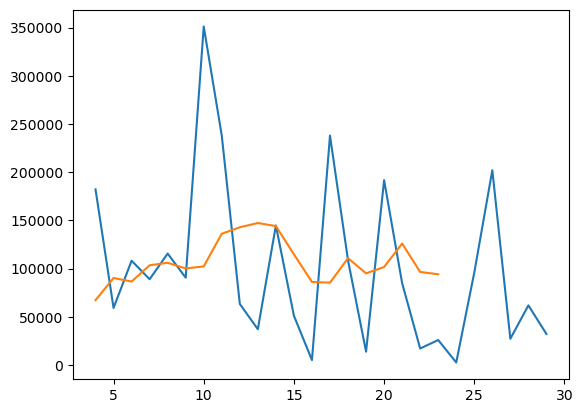

In [248]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel

# Make Time Series Predictions

In [20]:
predictions = model.predict(X_test)

array([130889.15, 141946.75,  93238.8 ,  81961.55, 106345.55,  86750.  ])